In [1]:
import h5py
import numpy as np
import keras
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model
from keras import backend as K
import plotting
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.special import expit
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [76]:
input_img=Input(shape= (40, 40, 1))
layer=input_img
layer=Conv2D(128, kernel_size=(3, 3),activation='relu',padding='same')(layer)
layer=MaxPooling2D(pool_size=(2, 2),padding='same')(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)
layer=MaxPooling2D(pool_size=(2, 2),padding='same')(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)
layer=Flatten()(layer)
layer=Dense(32, activation='relu')(layer)
layer=Dense(12)(layer)
encoded=layer

layer=Dense(32, activation='relu')(encoded)
layer=Dense(12800, activation='relu')(layer)
layer=Reshape((10,10,128))(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)
layer=UpSampling2D((2,2))(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)
layer=UpSampling2D((2,2))(layer)
layer=Conv2D(1, kernel_size=(3, 3),padding='same')(layer)
layer=Reshape((1,1600))(layer)
decoded=Reshape((40,40,1))(layer)

autoencoder=Model(input_img ,decoded)
autoencoder.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())
autoencoder.summary()
#autoencoder.load_weights("cnn200p1b128.h5")
autoencoder.save_weights('initcnn.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 40, 40, 128)       1280      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 10, 10, 128)       147584    
_________________________________________________________________
flatten_6 (Flatten)          (None, 12800)             0         
__________

In [3]:
f = h5py.File('./data/train_no_pile_100000a.h5','r')
x,y = f['features'][:], f['targets'][:]
ibg, isig = np.where(y == 0)[0], np.where(y == 1)[0]
xbg, ybg = x[ibg], y[ibg]
xsig, ysig = x[isig], y[isig]

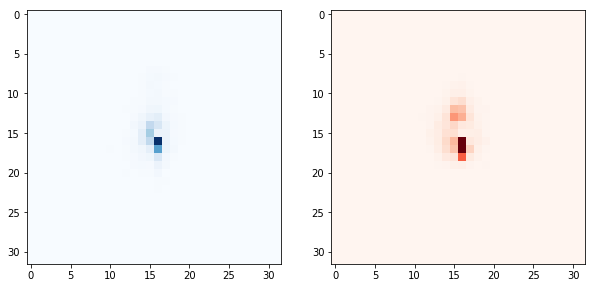

In [4]:
plotting.plot2_nAgg(0,1000,xbg,xsig,100*400,"traindata.png")

In [5]:
ft = h5py.File('./data/test_no_pile_50000a.h5','r')
xt,yt = ft['features'][:], ft['targets'][:]
ibgt, isigt = np.where(yt == 0)[0], np.where(yt == 1)[0]
xbgt, ybgt = xt[ibgt], yt[ibgt]
xsigt, ysigt = xt[isigt], yt[isigt]

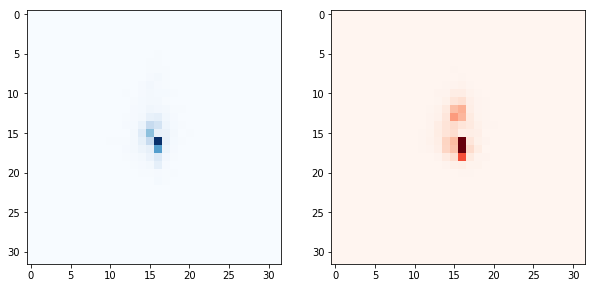

In [6]:
plotting.plot2_nAgg(0,1000,xbgt,xsigt,100*400,"testdata.png")

In [7]:
print(xbg.shape,ybg.shape,xsig.shape,ysig.shape)
print(xbgt.shape,ybgt.shape,xsigt.shape,ysigt.shape)

(50060, 1, 32, 32) (50060, 1) (49940, 1, 32, 32) (49940, 1)
(24925, 1, 32, 32) (24925, 1) (25075, 1, 32, 32) (25075, 1)


In [8]:
#xbg_tr; xbg_val; xbg_te
xbg_tr,ybg_tr=xbg[:40000],ybg[:40000]
xbg_val,ybg_val=xbg[40000:],ybg[40000:]
xsig_tr,ysig_tr=xsig[:40000],ysig[:40000]
xsig_val,ysig_val=xsig[40000:],ysig[40000:]
xbg_te,ybg_te = xbgt[:],ybgt[:]
xsig_te,ysig_te = xsigt[:],ysigt[:]

def flat(x):
    return x.reshape(x.shape[0],32,32)

xbg_tr = flat(xbg_tr)
xbg_val = flat(xbg_val)
xsig_tr = flat(xsig_tr)
xsig_val = flat(xsig_val)
xbg_te = flat(xbgt)
xsig_te = flat(xsigt)


print(xbg_tr.shape,ybg_tr.shape,xsig_tr.shape,ysig_tr.shape)
print(xbg_val.shape,ybg_val.shape,xsig_val.shape,ysig_val.shape)
print(xbg_te.shape,ybg_te.shape,xsig_te.shape,ysig_te.shape)

(40000, 32, 32) (40000, 1) (40000, 32, 32) (40000, 1)
(10060, 32, 32) (10060, 1) (9940, 32, 32) (9940, 1)
(24925, 32, 32) (24925, 1) (25075, 32, 32) (25075, 1)


In [9]:
A = np.array([[[1,2,9],[3,4,6],[6,7,8]],[[1,2,9],[3,4,6],[6,7,8]]])
print(A,A.shape)
np.pad(A, ((0,0),(4,4),(4,4)), 'constant').shape

[[[1 2 9]
  [3 4 6]
  [6 7 8]]

 [[1 2 9]
  [3 4 6]
  [6 7 8]]] (2, 3, 3)


(2, 11, 11)

In [10]:
def pad(x):
    return np.pad(x,((0,0),(4,4),(4,4)), 'constant')

xbg_tr = pad(xbg_tr)
xbg_val = pad(xbg_val)
xsig_tr = pad(xsig_tr)
xsig_val = pad(xsig_val)
xbg_te = pad(xbg_te)
xsig_te = pad(xsig_te)

In [11]:
print(xbg_tr.shape,xbg_val.shape,xbg_te.shape)
print(ybg_tr.shape,ybg_val.shape,ybg_te.shape)
print(xsig_tr.shape,xsig_val.shape,xsig_te.shape)
print(ysig_tr.shape,ysig_val.shape,ysig_te.shape)

(40000, 40, 40) (10060, 40, 40) (24925, 40, 40)
(40000, 1) (10060, 1) (24925, 1)
(40000, 40, 40) (9940, 40, 40) (25075, 40, 40)
(40000, 1) (9940, 1) (25075, 1)


In [12]:
def fold(x):
    return x.reshape(x.shape[0],x.shape[1],x.shape[2],1)

xbg_tr = fold(xbg_tr)
xbg_val = fold(xbg_val)
xsig_tr = fold(xsig_tr)
xsig_val = fold(xsig_val)
xbg_te = fold(xbg_te)
xsig_te = fold(xsig_te)

In [13]:
print(xbg_tr.shape,xbg_val.shape,xbg_te.shape)
print(ybg_tr.shape,ybg_val.shape,ybg_te.shape)
print(xsig_tr.shape,xsig_val.shape,xsig_te.shape)
print(ysig_tr.shape,ysig_val.shape,ysig_te.shape)

(40000, 40, 40, 1) (10060, 40, 40, 1) (24925, 40, 40, 1)
(40000, 1) (10060, 1) (24925, 1)
(40000, 40, 40, 1) (9940, 40, 40, 1) (25075, 40, 40, 1)
(40000, 1) (9940, 1) (25075, 1)


In [77]:
autoencoder.load_weights('initcnn.h5')
callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, 
                                           patience=10, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

historya = autoencoder.fit(xbg_tr, xbg_tr, epochs=20, batch_size=128,
                validation_data=(xbg_val,xbg_val),verbose=1,
                callbacks=callbacks)

Train on 40000 samples, validate on 10060 samples
Epoch 1/20
40000/40000 [==============================] - 17s 421us/step - loss: 6.8378 - val_loss: 2.9737
Epoch 2/20
40000/40000 [==============================] - 16s 402us/step - loss: 2.6175 - val_loss: 2.2602
Epoch 3/20
40000/40000 [==============================] - 16s 404us/step - loss: 2.1032 - val_loss: 1.9422
Epoch 4/20
40000/40000 [==============================] - 16s 405us/step - loss: 1.8229 - val_loss: 1.6872
Epoch 5/20
40000/40000 [==============================] - 16s 407us/step - loss: 1.6442 - val_loss: 1.5571
Epoch 6/20
40000/40000 [==============================] - 16s 408us/step - loss: 1.5152 - val_loss: 1.5444
Epoch 7/20
40000/40000 [==============================] - 16s 411us/step - loss: 1.3882 - val_loss: 1.5919
Epoch 8/20
40000/40000 [==============================] - 16s 410us/step - loss: 1.3070 - val_loss: 1.2988
Epoch 9/20
40000/40000 [==============================] - 16s 410us/step - loss: 1.2789 - val_

In [78]:
autoencoder.save_weights('cnn200p12b128.h5')

In [43]:
autoencoder.evaluate(xbg_te,xbg_te,batch_size=128)

24925/24925 [==============================] - 4s 141us/step


1.6780312735003717

In [44]:
autoencoder.evaluate(xsig_te,xsig_te,batch_size=128)

25075/25075 [==============================] - 4s 140us/step


4.537762330854878

In [18]:
imbg = autoencoder.predict(xbg_te,batch_size=128)
imsig = autoencoder.predict(xsig_te,batch_size=128)

In [17]:
print(imbg.shape,imsig.shape)

(24925, 40, 40, 1) (25075, 40, 40, 1)


In [18]:
for i in random.sample(range(1,24000),10):
    print("Sneak at random 10 bg/sig loss")
    print("Background testing:",np.sum((xbg_te[i]-imbg[i])**2)/(xbg_te.shape[1]))
    print("Signal testing:",np.sum((xsig_te[i]-imsig[i])**2)/(xsig_te.shape[1]))

Sneak at random 10 bg/sig loss
Background testing: 47.72554931640625
Signal testing: 22.039971923828126
Sneak at random 10 bg/sig loss
Background testing: 0.5683899879455566
Signal testing: 119.595654296875
Sneak at random 10 bg/sig loss
Background testing: 3.903703308105469
Signal testing: 21.190762329101563
Sneak at random 10 bg/sig loss
Background testing: 1.081679916381836
Signal testing: 58.91251220703125
Sneak at random 10 bg/sig loss
Background testing: 2.6488679885864257
Signal testing: 118.23182373046875
Sneak at random 10 bg/sig loss
Background testing: 0.6380675315856934
Signal testing: 29.733837890625
Sneak at random 10 bg/sig loss
Background testing: 0.9413893699645997
Signal testing: 41.46864624023438
Sneak at random 10 bg/sig loss
Background testing: 21.342857360839844
Signal testing: 93.96350708007813
Sneak at random 10 bg/sig loss
Background testing: 1.8948984146118164
Signal testing: 45.6987548828125
Sneak at random 10 bg/sig loss
Background testing: 41.34613952636719

In [19]:
print("Background testing:",np.sum((xbg_te[1]-imbg[1])**2)/(xbg_te.shape[1]))

Background testing: 3.7338840484619142


In [20]:
def nAgg(s,e,x,x_hat):
    oga = np.copy(x[s].reshape((40,40)))
    imga = np.copy(x_hat[s].reshape((40,40)))
#     f, ax = plt.subplots(1, 2, figsize=(10, 10))
#     ax[0].imshow(oga,cmap="Blues")
#     ax[0].set_title("Original")
#     ax[1].imshow(imga , cmap="Blues")
#     ax[1].set_title("Reconstructed")
#     plt.show()    
    for i in range(s+1,e):
        og = np.reshape(x[i],(40,40))
        img = np.reshape(x_hat[i],(40,40))
        oga += og
        imga += img
        
    return oga, imga

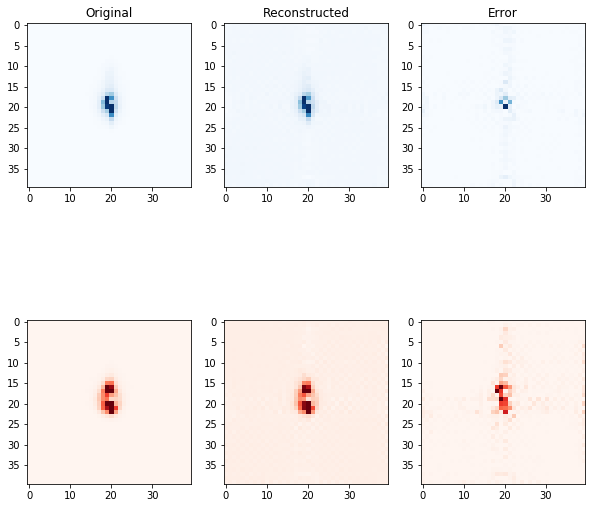

In [21]:
ogbg,imgbg = nAgg(0,10000,xbg_te,imbg)
ogsig,imgsig = nAgg(0,10000,xsig_te,imsig)

f, ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0][0].imshow(ogbg,cmap="Blues", vmax=100000)
ax[0][0].set_title("Original")
ax[0][1].imshow(imgbg , cmap="Blues" , vmax=100000)
ax[0][1].set_title("Reconstructed")
ax[0][2].imshow((ogbg-imgbg)**2/(32*32) , cmap="Blues", vmax=100000)
ax[0][2].set_title("Error")

ax[1][0].imshow(ogsig,cmap="Reds" , vmax=100000)
ax[1][1].imshow(imgsig , cmap="Reds" , vmax=100000)
ax[1][2].imshow((ogsig-imgsig)**2/(32*32) , cmap="Reds", vmax=100000)
0
plt.savefig("cnnaee.png")
plt.show()

In [56]:
def plot_al(history,aorl):
    plt.plot(history.history[aorl])
    plt.plot(history.history['val_'+aorl])
    plt.title('Dense Autoencoder '+("Accuracy" if aorl=="acc" else "Loss"))
    plt.ylabel(aorl)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

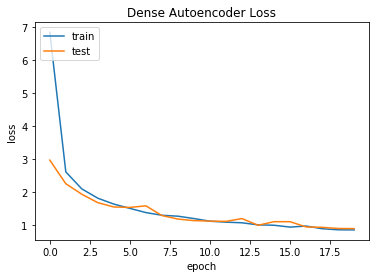

In [79]:
plot_al(historya,'loss')

In [69]:
xmixed = np.concatenate((xbg_te,xsig_te))
ymixed = np.concatenate((ybg_te,ysig_te))

In [70]:
print(xmixed.shape,ymixed.shape)

(50000, 40, 40, 1) (50000, 1)


In [80]:
imall = autoencoder.predict(xmixed,batch_size=128)

In [81]:
imall.shape

(50000, 40, 40, 1)

In [82]:
def evaluate(x,img):
    err = np.sum((x-img)**2)/(x.shape[0])
    #print(expit((err-65)/10))
    return expit(err), err

In [83]:
def preRoc(xs,x_hats):
    y_preds = []
    errs = []
    for i in range(xmixed.shape[0]):
        y_pred, errx = evaluate(xs[i],x_hats[i])
        y_preds.append(y_pred)
        errs.append(errx)
        
    #print(y_preds)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(ymixed.reshape(ymixed.shape[0]), 
                                      np.array(y_preds))
        roc_auc[i] = auc(fpr[i], tpr[i])
    print(roc_auc)
    return fpr,tpr,roc_auc, errs, y_preds

{0: 0.8045637194734752, 1: 0.8045637194734752}


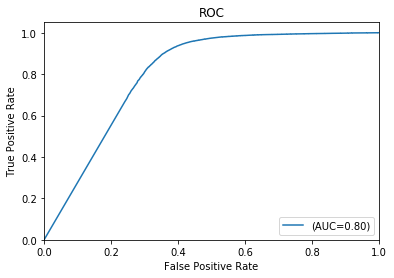

In [84]:
plt.figure()   
fpr,tpr,roc_auc,errs,y_preds = preRoc(xmixed,imall)
plt.plot(fpr[1], tpr[1],label="(AUC={:.2f})".format(roc_auc[0]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig("cnnaerocc.png")
plt.show()

In [29]:
errs = np.array(errs)
print(errs[:imbg.shape[0]].mean())
print(errs[imbg.shape[0]:].mean())
print(errs[0])

31.121513789589212
76.04655457323211
95.3077880859375


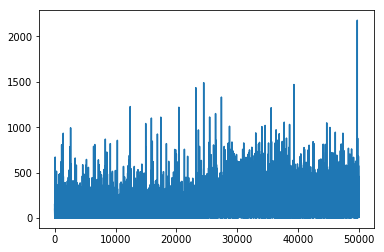

In [30]:
plt.figure()
plt.plot(errs)

In [31]:
y_preds = np.array(y_preds)
print(y_preds[:imbg.shape[0]].mean())
print(y_preds[imbg.shape[0]:].mean())
print(y_preds[1])

0.9140213706980758
0.9975265917993978
0.9766580415333771


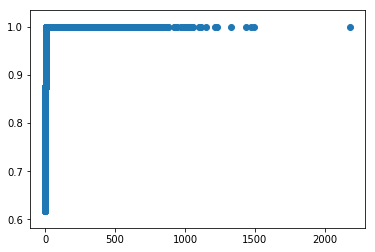

In [32]:
plt.figure()
plt.scatter(errs,y_preds)

In [35]:
def writePred(h5,ymixed,y_preds):
    hf = h5py.File(h5, 'w')
    ymixed = ymixed.reshape(ymixed.shape[0])
    assert ymixed.shape == y_preds.shape
    hf.create_dataset('y', data=ymixed)
    hf.create_dataset('y_pred', data=y_preds)
    hf.close()

In [36]:
writePred("cnnpred.h5",ymixed,y_preds)

In [39]:
ff = h5py.File('./cnnpred.h5','r')
ymixedd,y_predd = ff['y'][:], ff['y_pred'][:]
print(ymixedd.shape,y_predd.shape)

(50000,) (50000,)


In [40]:
fprr = dict()
tprr = dict()
roc_aucc = dict()
for i in range(2):
    fprr[i], tprr[i], _ = roc_curve(ymixedd, y_predd)
    roc_aucc[i] = auc(fprr[i], tprr[i])
print(roc_aucc)

{0: 0.7775764941884478, 1: 0.7775764941884478}


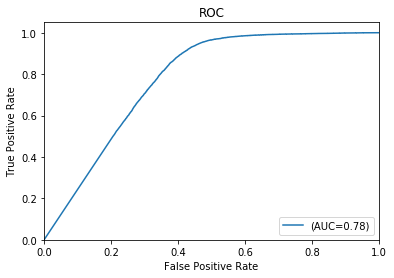

In [41]:
plt.plot(fprr[1], tprr[1],label="(AUC={:.2f})".format(roc_aucc[0]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig("cnnrocc.png")
plt.show()